In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

# print("Path to dataset files:", path)

In [2]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

path = os.path.join('..','data','books.csv')

# Data exploration and cleaning

In [3]:
books = pd.read_csv(path)

In [4]:
books.isna().mean()
# isbn is unique
# 2/3 of the dataset doesn't have subtitle
# only 4% of missing book descriptions: overall good, but why?

isbn13            0.000000
isbn10            0.000000
title             0.000000
subtitle          0.650367
authors           0.010573
categories        0.014537
thumbnail         0.048311
description       0.038473
published_year    0.000881
average_rating    0.006314
num_pages         0.006314
ratings_count     0.006314
dtype: float64

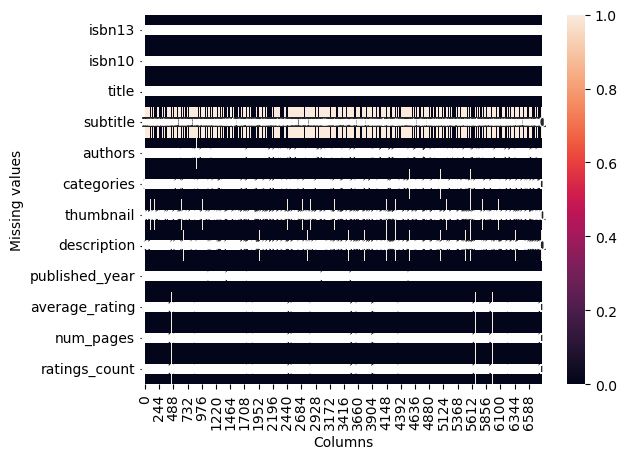

In [5]:
ax = plt.axes()
sns.heatmap(books.isna().transpose(), annot=True, cbar=True, ax=ax)

plt.xlabel("Columns")
plt.ylabel("Missing values")

plt.show()

# Subtitle is mostly missing. On its own is useless
# Categories, thumbnail, description are randomly missing
# Avg rating, num_pages, and ratings_count show a pattern of missing values

# The last columns are likely coming from another dataset
# Is there any bias in the type of missing descriptions?

Are books that have missing descriptions more likely to be older or shorter?
We are not going to use books with missing descriptions, but we need to make sure that removing such books won't induce a bias in the other variables.

How do the missing variables correlate with the a "missing descriptions" flag?

In [6]:
books['missing_description'] = books.description.isna()
books['age_of_book'] = pd.Timestamp.now().year - books['published_year']

In [7]:
columns_of_interes = ['num_pages', 'age_of_book', 'missing_description', 'average_rating']
correlation_matrix = books[columns_of_interes].corr(method='spearman') # Spearman appropriate for non-continuous values

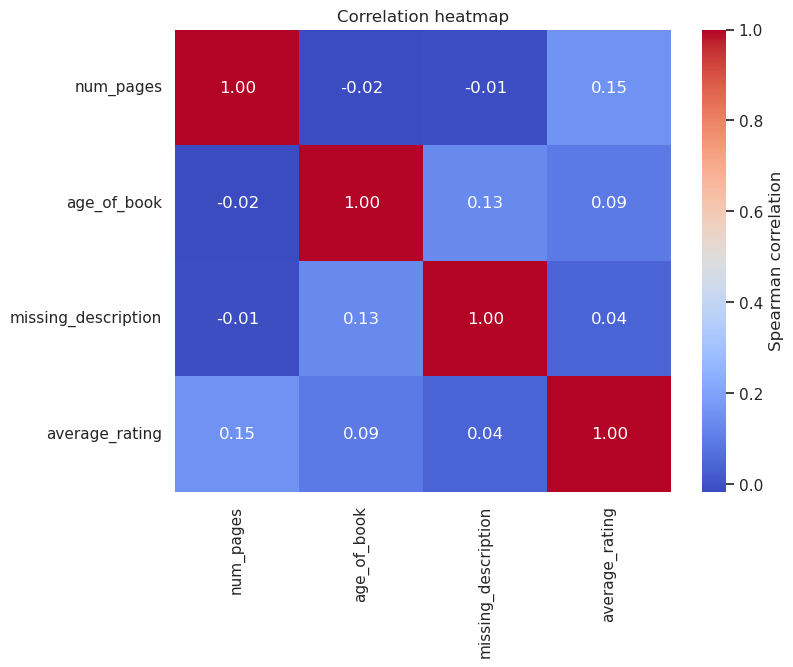

In [8]:
sns.set_theme(style="white")
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                      cbar_kws={"label":"Spearman correlation"})
heatmap.set_title("Correlation heatmap")
plt.show()

Correlation values with `missing_description` are not very stron, so we can rest assured that removing books with missing descriptions won't bias the overall distributions.

Because we have a small number of observations with missing values, there is no pattern in terms of "missingness", and replacing the descriptions would be cumbersome, it is safe to delete observations with missing values.

How many books will that removal cost?

In [9]:
n_removed_books = books.query("description.isna() or num_pages.isna() or average_rating.isna() or published_year.isna()").shape[0]
n_total_books = books.shape[0]

f"We would remove {n_removed_books}, which represent the {n_removed_books/n_total_books:.2%} of the whole dataset."

'We would remove 303, which represent the 4.45% of the whole dataset.'

In [10]:
books_missing = books.query("~(description.isna() or num_pages.isna() or average_rating.isna() or published_year.isna())").copy()
books_missing.shape

(6507, 14)

Let's now go back to the categories field: it has too many different values!

In [11]:
books.categories.unique().shape

(568,)

In [12]:
books.categories.unique()

array(['Fiction', 'Detective and mystery stories', 'American fiction',
       'Christian life', 'Authors, English', 'Africa, East',
       'Hyland, Morn (Fictitious character)', 'Adventure stories',
       'Arthurian romances', 'Fantasy fiction', nan, 'English drama',
       'Country life', 'English fiction', 'Clergy',
       'Aubrey, Jack (Fictitious character)',
       'Detective and mystery stories, English', 'Black Death',
       'Human cloning', 'Science fiction', 'Great Britain',
       'American essays', 'China', 'Capitalism', 'Ireland',
       'Juvenile Fiction', "Children's stories, English",
       'Male friendship', 'Literary Collections',
       'Beresford, Tommy (Fictitious character)',
       'Imaginary wars and battles', 'Dysfunctional families',
       'Poirot, Hercule (Fictitious character)', 'Christmas stories',
       'Marple, Jane (Fictitious character)', 'Belgians',
       'Battle, Superintendent (Fictitious character)',
       'Baggins, Frodo (Fictitious character

How does the distribution look like?

In [13]:
books_missing.categories.value_counts().to_frame()

# The distribution is very uneven!
# We will need to normalize it (later on the analysis)

,count
categories,
Fiction,2523
Juvenile Fiction,534
Biography & Autobiography,391
History,258
Literary Criticism,164
...,...
English essays,1
Inventions,1
Building laws,1


Let's now take a look at the descriptions category. It needs to be meaningful and contain enough information about what the book is about so we can recommend it.

In [14]:
books_missing['description']

0       A NOVEL THAT READERS and critics have been eag...
1       A new 'Christie for Christmas' -- a full-lengt...
2       Volume Two of Stephen Donaldson's acclaimed se...
3       A memorable, mesmerizing heroine Jennifer -- b...
4       Lewis' work on the nature of love divides love...
                              ...                        
6803    This book tells the tale of a man who goes on ...
6804    Wisdom to Create a Life of Passion, Purpose, a...
6805    This collection of the timeless teachings of o...
6808    Since the three volume edition ofHegel's Philo...
6809    This is a jubilant and rewarding collection of...
Name: description, Length: 6507, dtype: object

There are some very short descriptions which are useless. Let's count the number of words in the description:

In [15]:
books_missing.loc[:,'words_in_description'] = books_missing['description'].str.split().str.len()

<Axes: >

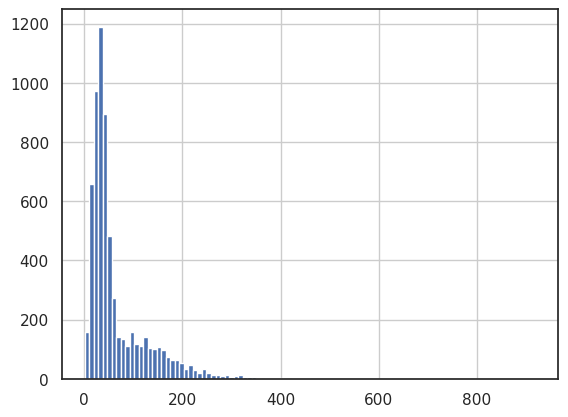

In [16]:
books_missing.words_in_description.hist(bins=100)

There is no natural breakpoint of descriptions that are too short and those that are too long. Arbitrarily, we will choose a number of words out of a "gut feeling".

In [17]:
books_missing.query("words_in_description.between(1,4)").description

# These descriptions are not helpful at all

6                                           Donation.
11                                     Fantasy-roman.
748              Includes bibliographical references.
770                             Bound For Oregon (PB)
775                                No Marketing Blurb
812                                No Marketing Blurb
857                          First published in 1813.
944                         Edited by Maurice Hindle.
953                        DEFOE/ROBINSON CRUSOE (BC)
954                             Edited by John Carey.
962                         ALLEN/GETTING THINGS DONE
1054                            GILBERT/EAT PRAY LOVE
1056    "Graham Greene centennial, 1904-2004"--Cover.
1060                   STEINBECK/GRAPES OF WRATH (BC)
1346                                   Fantasy-roman.
1546                                      Winter 2003
1610                                      Winter 1999
1813                             National bestseller.
1981                        

In [18]:
pd.options.display.max_colwidth = 150
books_missing.query("words_in_description.between(5, 14)").description

# Still not much information give

2       Volume Two of Stephen Donaldson's acclaimed second trilogy featuing the compelling anti-hero Thomas Covenant.
38                                     Koko is Peter Straub's foray into the psychological horror of the Vietnam War.
70                                                             A matter of life and death - and the Throne of England
77                                                                                     Nonsense rhyming story. 4 yrs+
84                                                  A study guide for the novel There's a Boy in the Girl's bathroom.
                                                            ...                                                      
6715                         The first comprehensive guide to addressing Native American issues in teaching children.
6726                                                                   Presents two complete novels from Henry James.
6757                                                    

In [19]:
pd.options.display.max_colwidth = 150
books_missing.query("words_in_description.between(15, 24)").description

# More meaningful descriptions

10                                         One of Sidney Sheldon's most popular and bestselling titles, repackaged and reissued for a new generation of fans.
32                                                               Tells the story of three generations of Chinese women, beginning at the turn of the century.
36                A magical and fantastic collection of early stories by one of the most original children's authors of the 20th century. For 8-11 year olds.
57                                         A young drifter finds more than he bargained for when he agrees to deliver a parcel to an English country house...
68                       A new 'The Doors of Perception' for the 21st century? A visionary journey from cynicism to shamanism by a brilliant young US writer.
                                                                                ...                                                                          
6767                                                

In [20]:
pd.options.display.max_colwidth = 300
books_missing.query("words_in_description.between(25, 34)").description

# This seems about right

9                                                     Kate Blackwell is an enigma and one of the most powerful women in the world. But at her ninetieth birthday celebrations there are ghosts of absent friends and absent enemies.
14                                               Available in the U.S. for the first time, this is the second volume in the exceptional Legends of the Riftwar series from "New York Times"-bestselling authors Feist and Rosenberg.
20                             It is 1937, and Charles Ashworth, a Canon to the Archbishop of Canterbury, is sent to untangle a web of self-delusion and corruption at the episcopal palace of the charismatic Bishop of Starbridge.
21                          Reissue of the author's most famous and well-loved work, the Starbridge series, six self-contained yet interconnected novels that explore the history of the Church of England through the 20th century.
46                                                               No one believes a l

We will use 25 words as a cutoff for the descriptions

In [21]:
book_missing_25_words = books_missing.query("words_in_description >= 25").copy()
book_missing_25_words.shape[0]

5197

A number of instances was lost, but either case we would have not been able to use them due to the lack of descriptive potential of the removed ones. Still, +5k books is a good number for the recommender.

We now need to decide what are we doing with the subtitle field. There are so many missing values that it is unusable on its own. However, there's a convention of pairing books with title and subtitle. Let's create a new field with a concatenation of both values, if the second one exists:

In [22]:
book_missing_25_words.loc[:,'title_and_subtitle'] = np.where(book_missing_25_words['subtitle'].isna(),
                                                             book_missing_25_words['title'],
                                                             book_missing_25_words[['title','subtitle']].astype(str) \
                                                                                                        .agg(": ".join, axis=1))

In [23]:
book_missing_25_words.title_and_subtitle.sample(10)

3681              Angels Don't Know Karate
4357                     The Sleeping Doll
4788                      The Female Brain
6591                The Conan Chronicles 1
5125    Mémoires, Plaidoiries Et Documents
4744                             Pet Peeve
4140                 Picture This: A Novel
1315               Three Plays by Kobo Abe
663            The Big Rock Candy Mountain
6622         Call of the Mall: How We Shop
Name: title_and_subtitle, dtype: object

Lastly, we want to create a new description column with the description and a unique identifier, which will become useful later on the analysis in the vector database.

In [24]:
book_missing_25_words.loc[:,'tagged_description'] = book_missing_25_words[['isbn13','description']].astype(str) \
                                                                                                   .agg(": ".join, axis=1)

In [25]:
book_missing_25_words.drop(columns=['subtitle', 'missing_description', 'age_of_book', 'words_in_description']) \
                     .to_csv('../data/books_cleaned.csv', index=False)